# Import data

In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [2]:
# !pip install seaborn --user
# !pip install image-classifiers
# !pip install tensorflow==1.14.0
# !pip install tensorflow-gpu==1.14.0
# !pip install keras-vis
# !pip install --upgrade scikit-image

In [3]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import keras
import pandas as pd
import random
import seaborn as sns
import vis ## keras-vis

from keras import optimizers, callbacks, Model
from keras.utils.io_utils import HDF5Matrix
from keras.models import Sequential
from keras.layers import GlobalAveragePooling2D, Conv2D, MaxPool2D, Flatten, Dense, Dropout, Activation, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
from sklearn import datasets, metrics
from vis.utils import utils
from vis.visualization import visualize_cam, visualize_saliency
from keras import activations

print("keras      {}".format(keras.__version__))
print("tensorflow {}".format(tf.__version__))
# %matplotlib inline

Using TensorFlow backend.


keras      2.2.4
tensorflow 1.14.0


In [4]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 1719227732149931372
, name: "/device:XLA_GPU:0"
device_type: "XLA_GPU"
memory_limit: 17179869184
locality {
}
incarnation: 11048998180190097485
physical_device_desc: "device: XLA_GPU device"
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 3956277893650788637
physical_device_desc: "device: XLA_CPU device"
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11330053735
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17254238398181920478
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"
]


# Classificando imagens em Landmarks

## Lendo o conjunto de dados

In [5]:
seed = random.seed(42)

sample_datagen = ImageDataGenerator(rescale=1./255)
base_path = '/home/ubuntu/landmarks/landmarks'
target_size = (331, 331)
input_shape = (331, 331, 3)

sample_generator = sample_datagen.flow_from_directory(base_path + '/subset_train',
                                                      target_size=target_size,
                                                      batch_size=32,
                                                      class_mode="sparse",
                                                      seed = seed)

sample_test_generator = sample_datagen.flow_from_directory(base_path + "/subset_test",
                                                           target_size = target_size,
                                                           batch_size = 32,
                                                           class_mode = "categorical",
                                                           seed = seed)

classes = [x for x in sample_generator.class_indices.keys()]
total_classes = np.max(sample_generator.labels) + 1

x_sample, y_sample = sample_generator.next()
x_sample_test, y_sample_test = sample_test_generator.next()
print('\n')
print('Showing y sample:', y_sample)
print('\n')
print('samples in train: %i' % sample_generator.labels.shape,
      'samples in test: %i' % sample_test_generator.labels.shape,
      'features: %s' % str(x_sample.shape[1:]),
      'classes: %i' % total_classes,
      sep='\n', end='\n\n')

print('shape:', x_sample.shape, x_sample_test.shape)
print(sample_generator.class_indices)
print(classes)

Found 12508 images belonging to 20 classes.
Found 3128 images belonging to 20 classes.


Showing y sample: [12. 14. 11.  2.  4. 11.  7. 12.  9.  5. 19.  8. 14. 17. 18.  3.  9. 10.
  1.  9. 16.  1. 14. 13.  2.  2. 12.  7.  6. 19.  6. 15.]


samples in train: 12508
samples in test: 3128
features: (331, 331, 3)
classes: 20

shape: (32, 331, 331, 3) (32, 331, 331, 3)
{'101399': 0, '120885': 1, '142644': 2, '146250': 3, '152827': 4, '165596': 5, '173511': 6, '178519': 7, '180901': 8, '186080': 9, '190822': 10, '20102': 11, '21253': 12, '31531': 13, '38482': 14, '47378': 15, '48522': 16, '56827': 17, '85758': 18, '97734': 19}
['101399', '120885', '142644', '146250', '152827', '165596', '173511', '178519', '180901', '186080', '190822', '20102', '21253', '31531', '38482', '47378', '48522', '56827', '85758', '97734']


## Lendo as 32 primeiras amostras no conjunto de treinamento

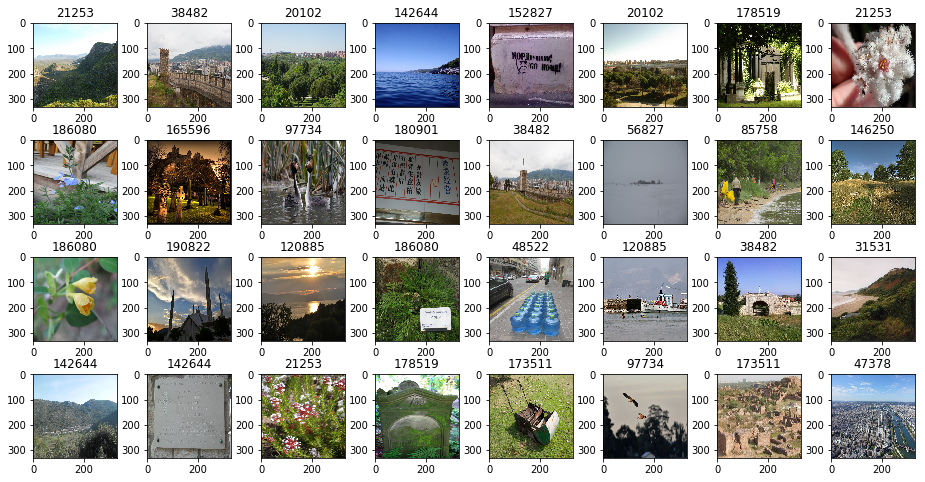

In [6]:
plt.figure(figsize=(16, 8))
for i in range(4 * 8):
    plt.subplot(4, 8, i+1)
    plt.subplots_adjust(hspace=0.4)
    plt.imshow(x_sample[i])
    plt.title("{}".format(classes[int(y_sample[i])]))

## Visualizando frequência das classes no conjunto

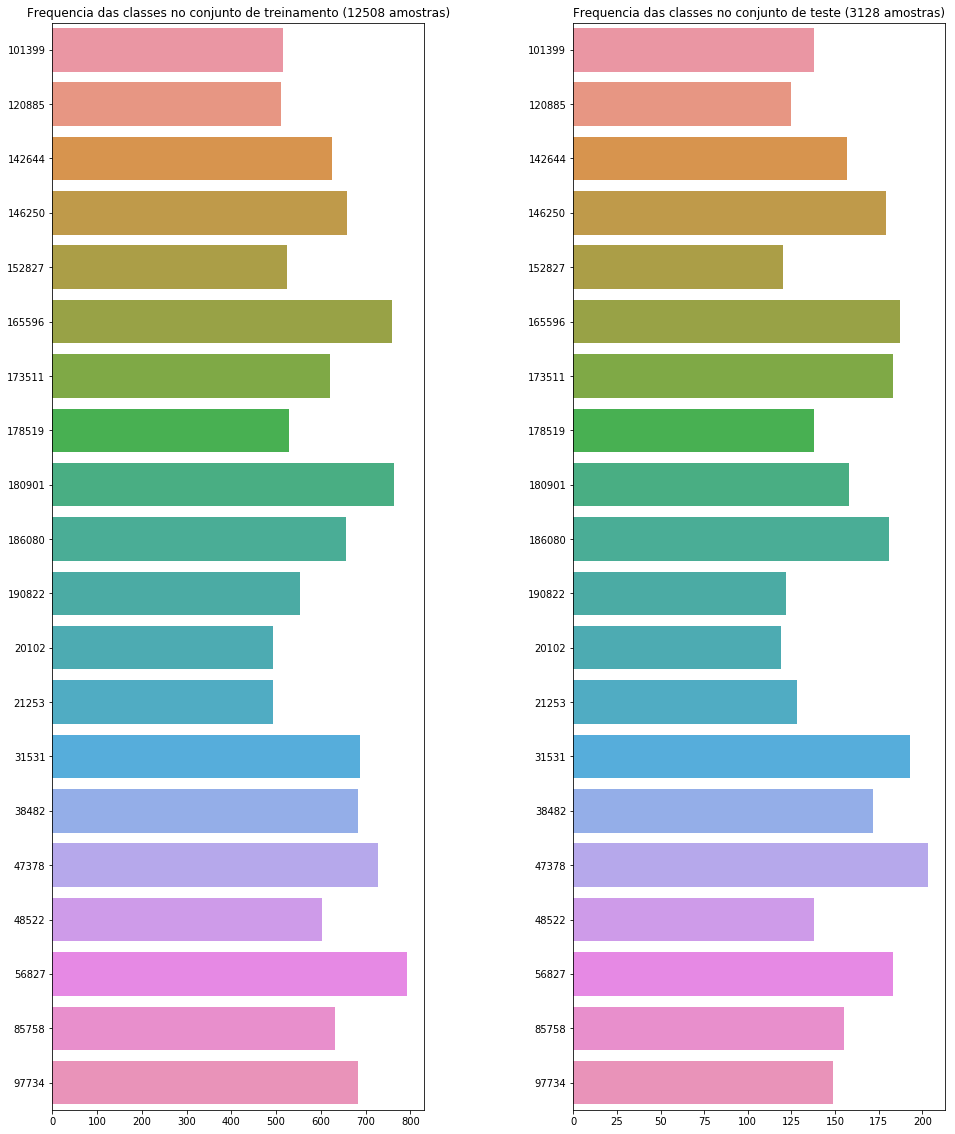

In [7]:
plt.figure(figsize=(16, 20))
plt.subplots_adjust(wspace=0.4)
plt.subplot(121)
plt.title('Frequencia das classes no conjunto de treinamento (%i amostras)' % len(sample_generator.labels))
_, counts = np.unique(sample_generator.labels, return_counts=True)
sns.barplot(counts, classes, orient='h')

plt.subplot(122)
plt.title('Frequencia das classes no conjunto de teste (%i amostras)' % len(sample_test_generator.labels))
_, counts = np.unique(sample_test_generator.labels, return_counts=True)
sns.barplot(counts, classes, orient='h')

# Preprocessamento das imagens de treino e validação

##Utilizaremos 20% da base de treinamento para validação

In [8]:
train_batch_size = 32 
val_batch_size = 32 

train_datagen = ImageDataGenerator(rescale = 1./255, validation_split = 0.2)
train_generator = train_datagen.flow_from_directory(base_path + "/subset_train",
                                                    target_size = target_size,
                                                    batch_size = train_batch_size,
                                                    class_mode = "categorical",
                                                    subset = 'training')

validation_generator = train_datagen.flow_from_directory(base_path + "/subset_train",
                                                         target_size = target_size,
                                                         batch_size = val_batch_size,
                                                         class_mode = "categorical",
                                                         subset ='validation')

Found 10016 images belonging to 20 classes.
Found 2492 images belonging to 20 classes.


# Parâmetros para treinamento e validação

In [9]:
from keras.applications.nasnet import NASNetLarge

opt = optimizers.RMSprop(lr = 0.0002,
                         decay = 1e-6)

basic_model = NASNetLarge(input_shape = input_shape,
                 weights = "imagenet",
                 include_top=False)

networkName = 'NasNetA-Tuning'

device = '/gpu:0'

epochs = 16

train_steps = train_generator.samples // train_batch_size

validation_steps = validation_generator.samples // val_batch_size

W0821 02:10:21.797719 140579176830720 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0821 02:10:21.798607 140579176830720 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0821 02:10:21.800977 140579176830720 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py:4185: The name tf.truncated_normal is deprecated. Please use tf.random.truncated_normal instead.

W0821 02:10:21.827086 140579176830720 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/backend/tensorflow_backend.py

343613440/343610240 [==============================] - 11s 0us/step


# Funções de auxílio

In [10]:
def model(base_model, name):

    # get layers and add average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D(name = 'global_mdc')(x)

    # add fully-connected layer
    x = Dense(512, activation='relu', name = 'dense_mdc')(x)

    # add output layer
    predictions = Dense(total_classes, activation='softmax', name = 'saida_mdc')(x)

    model = Model(inputs=base_model.input, outputs=predictions)

    # freeze pre-trained model area's layer
    for layer in base_model.layers:
        layer.trainable = False

    # update the weight that are added
    print('============== update weight that ared added ==============')
    model.compile(optimizer='rmsprop', loss='categorical_crossentropy')
    with tf.device(device):
      model.fit_generator(generator = train_generator,
                          steps_per_epoch = train_steps,
                          epochs = epochs // 4,
                          verbose = 1,
                          validation_data = validation_generator,
                          validation_steps = validation_steps,
                          callbacks = [callbacks.ModelCheckpoint('./' + name + '.weights.h5',
                                         save_best_only=True,
                                         verbose=1)])

    # choose the layers which are updated by training
    layer_num = utils.find_layer_idx(model, 'dense_mdc')
    for layer in model.layers:
        layer.trainable = True

    # update the weights

    print('============== fine tunning weights ==============')
    model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
    with tf.device(device):
      history = model.fit_generator(generator = train_generator,
                                    steps_per_epoch = train_steps,
                                    epochs = epochs,
                                    verbose = 1,
                                    validation_data = validation_generator,
                                    validation_steps = validation_steps,
                                    callbacks = [callbacks.ModelCheckpoint('./' + name + '.weights.h5',
                                         save_best_only=True,
                                         verbose=1)])
                    
    return history, model

In [11]:
def learning_curve_model(history):

  plt.figure(figsize=(16, 6))
  
  plt.subplot(121)  
  plt.plot(history.history['acc'])  
  plt.plot(history.history['val_acc'])  
  plt.title('model accuracy')  
  plt.ylabel('accuracy')  
  plt.xlabel('epoch')  
  plt.legend(['train', 'val'], loc='upper left')  
   
  # summarize history for loss  
   
  plt.subplot(122)  
  plt.plot(history.history['loss'])  
  plt.plot(history.history['val_loss'])  
  plt.title('model loss')  
  plt.ylabel('loss')  
  plt.xlabel('epoch')  
  plt.legend(['train', 'val'], loc='upper left')  
  plt.show()

In [12]:
def evaluate_generator_model(model, name, generator=validation_generator, steps=validation_steps):
  generator.reset()
  score_val = model.evaluate_generator(generator = generator, steps = steps)
  print('[' + name +'] loss:', score_val[0])
  print('[' + name +'] accuracy (NOT BALANCED):', score_val[1])
  return score_val

In [13]:
def predict_generator_model(model, generator = validation_generator, steps = validation_steps):
  generator.reset()

  y_val_final = []
  prediction_final = []
  for i in range(1, generator.samples // steps + 1):
    x_val, y_val = generator.next()
    probabilities = model.predict(x_val)

    prediction_final =  np.append(prediction_final, np.argmax(probabilities, axis=1))  
    y_val_final = np.append(y_val_final, np.argmax(y_val, axis=1))
    
  return y_val_final, prediction_final

In [14]:
def classification_report_model(y_val_final, prediction_final, labels=classes):
  print(metrics.classification_report(y_val_final, prediction_final, target_names=labels, output_dict= False))

  return metrics.classification_report(y_val_final, prediction_final, target_names=labels, output_dict= True)

In [15]:
def confusion_matrix_model(y_test, predictions, labels=classes):
  c = metrics.confusion_matrix(y_test, predictions)
  r = c / c.sum(axis=1).reshape(-1, 1)

  plt.figure(figsize=(18, 14))
  ax = sns.heatmap(r, linewidths=.5, cmap='YlGnBu', xticklabels=labels, yticklabels=labels);
  plt.show()
  
  showing = 10

  ordered_by_scores = np.argsort(np.diag(r))
  labels_sorted_by_score = np.asarray(labels)[ordered_by_scores]

  print('\nClasses incorretamente classificadas pelo modelo, com maior frequência:\n ',
        *('%s: %s\n' % pair for pair in zip(labels_sorted_by_score[:showing],
                                          np.diag(r)[ordered_by_scores])))

  print('\nClasses incorretamente classificadas pelo modelo, com menor frequência:\n ',
        *('%s: %s\n' % pair for pair in zip(labels_sorted_by_score[::-1][:showing],
                                          np.diag(r)[ordered_by_scores[::-1]])))
  return r

In [16]:
def evaluate_model(model, name, generator = validation_generator, steps = validation_steps):
  print('*** Prediction model - Part (1/4)****')
  (y_val, prediction) = predict_generator_model(model, generator, steps)
  print('*** Classification model - Part (2/4)****')
  metric = classification_report_model(y_val, prediction)
  print('*** Confusion matrix model - Part (3/4)****')
  r = confusion_matrix_model(y_val, prediction)
  
  print('*** Evaluate model - Part (4/4)****')
  evaluate_generator_model(model, name + '_val', generator, steps)
  evaluate_generator_model(model, name + '_train', train_generator, train_steps)

# ResNet50- Transfer Learning

## Fine Tuning

### Definindo a rede and training

In [17]:
history, tunning_model = model(basic_model, networkName)
tunning_model.save('./final.model.' + networkName + '.h5')

W0821 02:11:27.024387 140579176830720 deprecation_wrapper.py:119] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0821 02:11:27.145106 140579176830720 deprecation.py:323] From /home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


============== update weight that ared added ==============
Epoch 1/4
313/313 [==============================] - 973s 3s/step - loss: 1.3088 - val_loss: 0.9609

Epoch 00001: val_loss improved from inf to 0.96087, saving model to ./NasNetA-Tuning.weights.h5
Epoch 2/4
313/313 [==============================] - 951s 3s/step - loss: 0.8021 - val_loss: 1.0500

Epoch 00002: val_loss did not improve from 0.96087
Epoch 3/4
313/313 [==============================] - 953s 3s/step - loss: 0.6010 - val_loss: 1.0200

Epoch 00003: val_loss did not improve from 0.96087
Epoch 4/4
313/313 [==============================] - 953s 3s/step - loss: 0.4589 - val_loss: 1.1162

Epoch 00004: val_loss did not improve from 0.96087
============== fine tunning weights ==============
Epoch 1/16


ResourceExhaustedError: 2 root error(s) found.
  (0) Resource exhausted: OOM when allocating tensor with shape[32,168,42,42] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_1/RMSprop/gradients/zeros_844}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

	 [[metrics_1/acc/Mean/_17173]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

  (1) Resource exhausted: OOM when allocating tensor with shape[32,168,42,42] and type float on /job:localhost/replica:0/task:0/device:GPU:0 by allocator GPU_0_bfc
	 [[{{node training_1/RMSprop/gradients/zeros_844}}]]
Hint: If you want to see a list of allocated tensors when OOM happens, add report_tensor_allocations_upon_oom to RunOptions for current allocation info.

0 successful operations.
0 derived errors ignored.

In [ ]:
learning_curve_model(history)

## Evaluating model

In [ ]:
evaluate_model(tunning_model, networkName) 

## Check error

In [ ]:
validation_generator.reset()

x_sample, y_sample = validation_generator.next()
print('shape sample:', x_sample.shape)
print('label:', np.argmax(y_sample[0], axis=-1) )
plt.imshow(x_sample[0])
plt.show()

y_pred = tunning_model.predict(x_sample)
class_idxs_sorted = np.argsort(y_pred[0].flatten())[::-1]
topNclass = 5
for i, idx in enumerate(class_idxs_sorted[:topNclass]):
    print("Top {} predicted class:     Pr(Class={:18} [index={}])={:5.4f}"
          .format(i + 1, classes[idx], idx, y_pred[0,idx]))

In [ ]:
# gradient weighted class activation map (Grad-CAM)
layer_idx = utils.find_layer_idx(tunning_model, 'saida_mdc')
final_conv_layer = utils.find_layer_idx(tunning_model, 'res5c_branch2c')

In [ ]:
# swap softmax with linear
tunning_model.layers[layer_idx].activation = activations.linear
model_mod = utils.apply_modifications(tunning_model)

In [ ]:
class_idx  = class_idxs_sorted[0]
seed_input = x_sample[0]

grad_top1  = visualize_cam(model_mod, 
                           layer_idx, 
                           class_idx, 
                           seed_input, 
                           penultimate_layer_idx = final_conv_layer,
                           backprop_modifier = None,
                           grad_modifier = None)

fig, axes = plt.subplots(1,2,figsize=(14,5))
axes[0].imshow(seed_input)
axes[1].imshow(seed_input)
i = axes[1].imshow(grad_top1,cmap="jet",alpha=0.5)
fig.colorbar(i)
fig.suptitle("Pr(class={}) = {:5.2f}".format(
                      classes[class_idx],
                      y_pred[0,class_idx]))

In [ ]:
def plot_map(orignal, grads):
    fig, axes = plt.subplots(1,2,figsize=(14,5))
    axes[0].imshow(orignal)
    axes[1].imshow(orignal)
    i = axes[1].imshow(grads,cmap="jet",alpha=0.5)
    fig.colorbar(i)
    fig.suptitle("Pr(class={}) = {:5.2f}".format(
                      classes[class_idx],
                      y_pred[0,class_idx]))

In [ ]:
for class_idx in class_idxs_sorted[:topNclass]:
    grads  = visualize_cam(model_mod,
                           layer_idx,
                           class_idx, 
                           seed_input,
                           penultimate_layer_idx = final_conv_layer,
                           backprop_modifier     = None,
                           grad_modifier         = None)
    plot_map(seed_input, grads)